In [6]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import permutations, product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from test_utilities import run_tests_params
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc read-aloud"><h2>--- Day 11: Space Police ---</h2><p>On the way to Jupiter, you're <a href="https://www.youtube.com/watch?v=KwY28rpyKDE">pulled over</a> by the <em>Space Police</em>.</p>
<p>"Attention, unmarked spacecraft! You are in violation of Space Law! All spacecraft must have a clearly visible <em>registration identifier</em>! You have 24 hours to comply or be sent to <a href="https://www.youtube.com/watch?v=BVn1oQL9sWg&amp;t=5">Space Jail</a>!"</p>
<p>Not wanting to be sent to Space Jail, you radio back to the Elves on Earth for help. Although it takes almost three hours for their reply signal to reach you, they send instructions for how to power up the <em>emergency hull painting robot</em> and even provide a small <a href="9">Intcode program</a> (your puzzle input) that will cause it to paint your ship appropriately.</p>
<p>There's just one problem: you don't have an emergency hull painting robot.</p>
<p>You'll need to build a new emergency hull painting robot. The robot needs to be able to move around on the grid of square panels on the side of your ship, detect the color of its current panel, and paint its current panel <em>black</em> or <em>white</em>. (All of the panels are currently <em>black</em>.)</p>
<p>The Intcode program will serve as the brain of the robot. The program uses input instructions to access the robot's camera: provide <code>0</code> if the robot is over a <em>black</em> panel or <code>1</code> if the robot is over a <em>white</em> panel. Then, the program will output two values:</p>
<ul>
<li>First, it will output a value indicating the <em>color to paint the panel</em> the robot is over: <code>0</code> means to paint the panel <em>black</em>, and <code>1</code> means to paint the panel <em>white</em>.</li>
<li>Second, it will output a value indicating the <em>direction the robot should turn</em>: <code>0</code> means it should turn <em>left 90 degrees</em>, and <code>1</code> means it should turn <em>right 90 degrees</em>.</li>
</ul>
<p>After the robot turns, it should always move <em>forward exactly one panel</em>. The robot starts facing <em>up</em>.</p>
<p>The robot will continue running for a while like this and halt when it is finished drawing.  Do not restart the Intcode computer inside the robot during this process.</p>
<p>For example, suppose the robot is about to start running.  Drawing black panels as <code>.</code>, white panels as <code>#</code>, and the robot pointing the direction it is facing (<code>&lt; ^ &gt; v</code>), the initial state and region near the robot looks like this:</p>
<pre><code>.....
.....
..^..
.....
.....
</code></pre>
<p>The panel under the robot (not visible here because a <code>^</code> is shown instead) is also black, and so any input instructions at this point should be provided <code>0</code>. Suppose the robot eventually outputs <code>1</code> (paint white) and then <code>0</code> (turn left). After taking these actions and moving forward one panel, the region now looks like this:</p>
<pre><code>.....
.....
.&lt;#..
.....
.....
</code></pre>
<p>Input instructions should still be provided <code>0</code>. Next, the robot might output <code>0</code> (paint black) and then <code>0</code> (turn left):</p>
<pre><code>.....
.....
..#..
.v...
.....
</code></pre>
<p>After more outputs (<code>1,0</code>, <code>1,0</code>):</p>
<pre><code>.....
.....
..^..
.##..
.....
</code></pre>
<p>The robot is now back where it started, but because it is now on a white panel, input instructions should be provided <code>1</code>.  After several more outputs (<code>0,1</code>, <code>1,0</code>, <code>1,0</code>), the area looks like this:</p>
<pre><code>.....
..&lt;#.
...#.
.##..
.....
</code></pre>
<p>Before you deploy the robot, you should probably have an estimate of the area it will cover: specifically, you need to know the <em>number of panels it paints at least once</em>, regardless of color. In the example above, the robot painted <em><code>6</code> panels</em> at least once. (It painted its starting panel twice, but that panel is <a href="https://www.youtube.com/watch?v=KjsSvjA5TuE">still only counted once</a>; it also never painted the panel it ended on.)</p>
<p>Build a new emergency hull painting robot and run the Intcode program on it. <em>How many panels does it paint at least once?</em></p>
</article>


In [7]:
from typing import Generator

from more_itertools import minmax
from tabulate import tabulate


class IntcodeComputer:
    def __init__(self, s: str) -> None:
        self.state = {a: int(i) for a, i in enumerate(s.split(","))}
        self.ip = 0

    def run(self, reset=True) -> Generator[int | None, int, None]:
        if reset:
            self.ip = 0

        offset = 0

        while True:
            mode_c, mode_b, mode_a, opcode = self.opcode()

            if opcode == 1:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = c + b
            elif opcode == 2:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = c * b
            elif opcode == 3:
                f = yield
                self.state[self.adress(mode_c, offset)] = f
            elif opcode == 4:
                c = self.value(mode_c, offset)
                yield c
            elif opcode == 5:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                if c != 0:
                    self.ip = b
            elif opcode == 6:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                if c == 0:
                    self.ip = b
            elif opcode == 7:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = 1 if c < b else 0
            elif opcode == 8:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = 1 if c == b else 0
            elif opcode == 9:
                offset += self.value(mode_c, offset)
            elif opcode == 99:
                return
            else:
                raise ValueError("1202 program alarm")

    def opcode(self):
        code = self.state[self.ip]
        self.ip += 1
        opcode = code % 100
        code //= 100
        mode_c = code % 10
        code //= 10
        mode_b = code % 10
        code //= 10
        mode_a = code % 10
        return mode_c, mode_b, mode_a, opcode

    def value(self, mode: int, offset: int) -> int:
        adress = self.adress(mode, offset)
        if adress > -1:
            if adress not in self.state:
                self.state[adress] = 0
            return self.state[adress]

        raise ValueError(
            f"Adress should be bigger then 0: adress={self.state[self.ip] + offset}"
        )

    def adress(self, mode: int, offset: int) -> int:
        ip = self.ip
        self.ip += 1

        if mode == 0:
            return self.state[ip]

        if mode == 1:
            return ip

        if mode == 2:
            return self.state[ip] + offset

        raise ValueError(f"Unknown adress mode: mode={mode}")

    def __repr__(self) -> str:
        return ",".join(str(i) for i in self.state)


class EmergencyhullPaintingRobot:

    def __init__(self, puzzle: str) -> None:
        self.ic = IntcodeComputer(puzzle)
        self.grid = defaultdict(int)
        self.pos = 0, 0
        self.dir = -1, 0

    def turn_left(self) -> None:
        self.dir = -self.dir[1], self.dir[0]

    def turn_right(self) -> None:
        self.dir = self.dir[1], -self.dir[0]

    def paint(self) -> None:
        gen = self.ic.run()
        gen.send(None)

        try:
            while True:
                paint = gen.send(
                    self.grid[self.pos]
                )  #  When execution picks up after yield, i will take the value that is sent.
                self.grid[self.pos] = paint
                turn = gen.send(None)
                gen.send(None)  # need one for getting back to input

                if turn == 0:
                    self.turn_left()
                else:
                    self.turn_right()

                self.pos = self.pos[0] + self.dir[0], self.pos[1] + self.dir[1]
        except StopIteration:
            return

    def panels_painted(self) -> int:
        return len(self.grid)

    def display(self) -> None:
        r_min, r_max = minmax(r for r, _ in self.grid.keys())
        c_min, c_max = minmax(c for _, c in self.grid.keys())

        dis = [
            [self.grid[(r + r_min, c + c_min)] for c in range(c_max - c_min + 1)]
            for r in range(r_max - r_min + 1)
        ]

        plt.imshow(dis, cmap="binary")
        plt.show()

    @classmethod
    def count_panels_painted(cls, program) -> int:
        epr = cls(program)
        epr.paint()
        return epr.panels_painted()

    @classmethod
    def show_display(cls, program) -> None:
        epr = cls(program)
        epr.grid[(0, 0)] = 1
        epr.paint()
        epr.display()


with open("../input/day11.txt") as f:
    puzzle = f.read()


print(f"Part I: {EmergencyhullPaintingRobot.count_panels_painted(puzzle)}")

Part I: 2160


<link href="style.css" rel="stylesheet"></link>
<main>
<p>Your puzzle answer was <code>2160</code>.</p>
<p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>You're not sure what it's trying to paint, but it's definitely not a <em>registration identifier</em>.  The Space Police are getting impatient.</p>
<p>Checking your external ship cameras again, you notice a white panel marked "emergency hull painting robot starting panel". The rest of the panels are <em>still black</em>, but it looks like the robot was expecting to <em>start on a white panel</em>, not a black one.</p>
<p>Based on the <span title="Just be glad it wasn't a full set of Space Law Space Books; the number of pages is *astronomical*.">Space Law Space Brochure</span> that the Space Police attached to one of your windows, a valid registration identifier is always <em>eight capital letters</em>. After starting the robot on a single <em>white panel</em> instead, <em>what registration identifier does it paint</em> on your hull?</p>
</article>

</main>


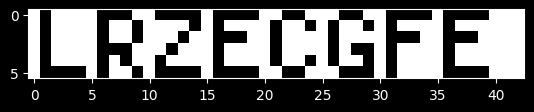

In [8]:
EmergencyhullPaintingRobot.show_display(puzzle)

In [9]:
print("Part II: LRZECGFE")

Part II: LRZECGFE


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>LRZECGFE</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>

</main>
